In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost with Mean Encoded NAICS
Same as the baseline but include the mean encoded NAICS (and NAICS sector)

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(425594, 49)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(425594, 49)

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [10]:
predictor_features = setup.predictor_features + ['menc_NAICS', 'menc_NAICS_sector']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'menc_NAICS_sector']


In [11]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_NAICS,menc_NAICS_sector
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000,425594.000000,425594.000000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858,0.203958,0.203074
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709,0.095447,0.045198
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.012821,0.074573
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000,0.130414,0.189649
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.201126,0.217493
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000,0.267081,0.225793
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,0.494305,0.283068


In [12]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_NAICS,menc_NAICS_sector,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,-0.024551,-0.011011,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.003968,-0.001322,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.077294,-0.020431,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,-0.190538,-0.090225,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.025681,-0.021280,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.058798,0.016961,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.030764,0.057686,-0.011047
menc_NAICS,-0.024551,0.003968,-0.077294,-0.190538,0.025681,0.058798,0.030764,1.000000,0.459558,0.239223
menc_NAICS_sector,-0.011011,-0.001322,-0.020431,-0.090225,-0.021280,0.016961,0.057686,0.459558,1.000000,0.112353
target,-0.027838,-0.009540,-0.076836,-0.122857,0.014277,0.054391,-0.011047,0.239223,0.112353,1.000000


In [13]:
with open(Path(setup.temp_path).joinpath('04_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [14]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [15]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':20})

In [16]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 20)

In [17]:
xgb_model = xgb_model.set_params(**xgb_params)

In [18]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49886	validation_1-logloss:0.50175
[1]	validation_0-logloss:0.49172	validation_1-logloss:0.49463
[2]	validation_0-logloss:0.48577	validation_1-logloss:0.48869
[3]	validation_0-logloss:0.48067	validation_1-logloss:0.48359
[4]	validation_0-logloss:0.47628	validation_1-logloss:0.47921
[5]	validation_0-logloss:0.47244	validation_1-logloss:0.47541
[6]	validation_0-logloss:0.46924	validation_1-logloss:0.47223
[7]	validation_0-logloss:0.46644	validation_1-logloss:0.46943
[8]	validation_0-logloss:0.46406	validation_1-logloss:0.46705
[9]	validation_0-logloss:0.46202	validation_1-logloss:0.46503
[10]	validation_0-logloss:0.46024	validation_1-logloss:0.46326
[11]	validation_0-logloss:0.45871	validation_1-logloss:0.46172
[12]	validation_0-logloss:0.45738	validation_1-logloss:0.46039
[13]	validation_0-logloss:0.45618	validation_1-logloss:0.45920
[14]	validation_0-logloss:0.45518	validation_1-logloss:0.45823
[15]	validation_0-logloss:0.45430	validation_1-logloss:0.45738
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [19]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [20]:
xgb_model.save_model(Path(setup.temp_path).joinpath('04_MODEL_xgboost.json'))

In [21]:
with open(Path(setup.temp_path).joinpath('04_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [22]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [23]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.189325,0.102427,0.035223,0.534849,0.179640
1,0.274032,0.092426,0.035223,0.534849,0.283759


## Decision Threshold
Max f1, on training data

In [24]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [25]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [26]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('04_REPORT_thresh_tune.csv'), index=False)

In [27]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.448590
12,0.24,0.448282


##### Apply decision threshold
All datasets

In [28]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [29]:
pred_df['predict_bin'].value_counts()

predict_bin
0    363813
1    324268
Name: count, dtype: int64

In [30]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('04_DATA_combined_predictions.parquet'))

## Metrics

In [31]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('43_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.627354,0.440896,0.315304,0.732775,0.367977,0.724336,NaN
1,train,0.627391,0.448590,0.320660,0.746352,0.377084,0.728959,NaN
2,val,0.628264,0.451512,0.323998,0.744537,0.376133,0.727697,NaN
0,test,0.626832,0.447361,0.320316,0.741432,0.379542,0.728372,0.0
1,test,0.628973,0.419768,0.299010,0.704141,0.332871,0.714185,1.0


## Lift
Test data

In [32]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

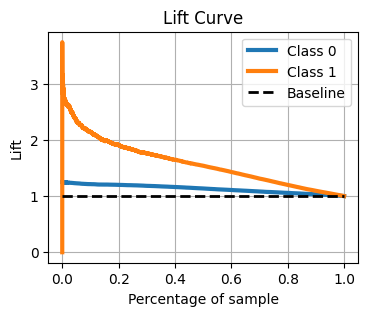

In [33]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [34]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [35]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('04_REPORT_importance_gain.csv'), index=True)

In [36]:
feat_impgain.head()

,importance
urban_flag,633.374084
menc_NAICS,348.312103
LowDoc,310.779510
DisbursementGross,191.861832
NoEmp,58.610043


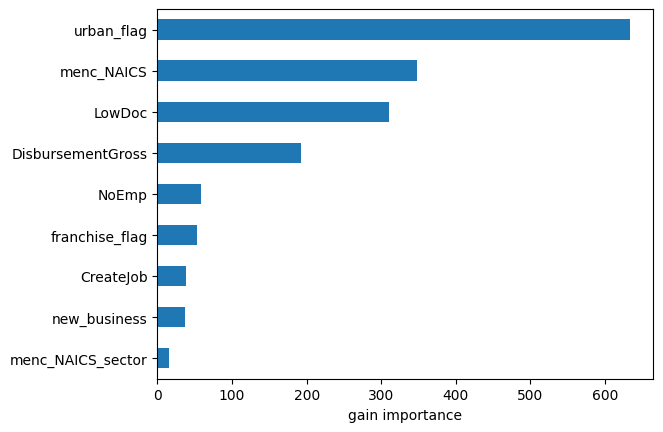

In [37]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_importance_gain.png'))

##### Permutation Importance

In [38]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [39]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [40]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_NAICS,0.081582,0.081582
3,DisbursementGross,0.052941,0.052941
5,urban_flag,0.032082,0.032082
1,CreateJob,0.012089,0.012089
2,LowDoc,0.011110,0.011110


In [41]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('04_DATA_importance_perturb.csv'),
            index=False)

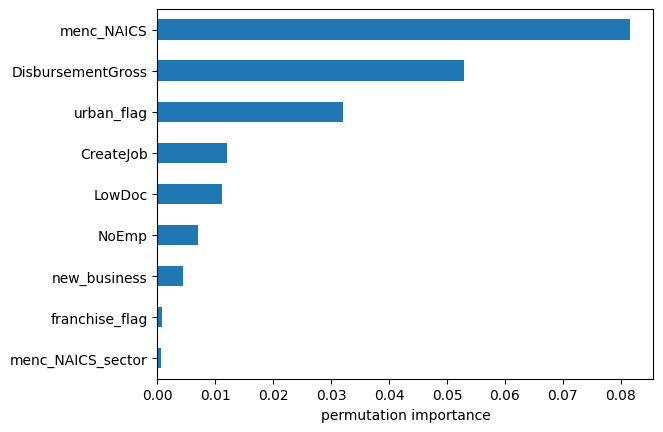

In [42]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('04_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [43]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_NAICS'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [44]:
plt.close()

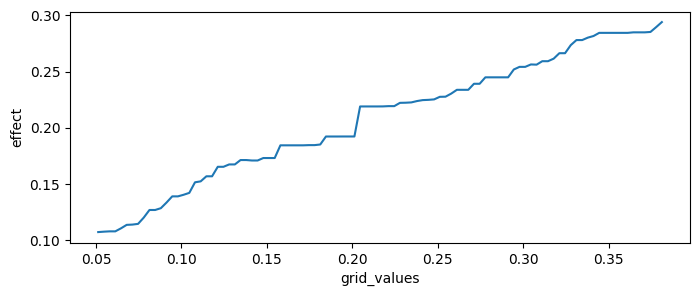

In [45]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('04_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')